In [53]:
import numpy as np
import pandas as pd
#import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from myfunc import replace_nans, plot_kde
#%matplotlib qt5
%matplotlib inline

In [3]:
weak_carbon_path = '../resources/weak_carbon.csv'
golden_carbon_path = '../resources/carbon_gold_distance.csv'
weak_carbon_catalog = pd.read_csv(weak_carbon_path)
golden_carbon_catalog = pd.read_csv(golden_carbon_path)

GALAXY_RA = 255.7081
GALAXY_DEC = -27.0167
GALAXY_DISTANCE = 8657.26

galaxy_ra_rad = np.deg2rad(GALAXY_RA)
galaxy_dec_rad = np.deg2rad(GALAXY_DEC)
galaxy_x = GALAXY_DISTANCE * np.cos(galaxy_dec_rad) * np.cos(galaxy_ra_rad)
galaxy_y = GALAXY_DISTANCE * np.cos(galaxy_dec_rad) * np.sin(galaxy_ra_rad)
galaxy_z = GALAXY_DISTANCE * np.sin(galaxy_dec_rad)


In [4]:
weak_carbon_catalog.describe()

,source_id,ra,dec,bp_rp,teff_gspphot,logg_gspphot,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,confidence,shap_value,R482.3,R527.1,R773.3,R895.0,TIC,RAJ2000,DEJ2000,errHalfMaj,errHalfMin,errPosAng,HIP,objID,GAIA,APASS,KIC,pmRA,e_pmRA,pmDE,e_pmDE,Plx,e_Plx,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag_x,e_gmag_x,...,E_Mass_xa,e_Rad_x,E_Rad_xa,e_rho_x,E_rho_xa,e_logg_x,E_logg_xa,e_Lum_x,E_Lum_xa,e_Dist_x,E_Dist_xa,e_Teff_x,E_Teff_xa,BPmag,e_BPmag,RPmag,e_RPmag,q_Gaia,Clist,e_RAJ2000,e_DEJ2000,RAOdeg,DEOdeg,e_RAOdeg,e_DEOdeg,RadFl,WDFl,ID,angDist,Source,RA_ICRS,DE_ICRS,rgeo,b_rgeo_x,B_rgeo_xa,rpgeo,b_rpgeo_x,B_rpgeo_xa,Flag_x,angDist_x
count,4.510000e+02,451.000000,451.000000,451.000000,227.000000,227.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,4.510000e+02,451.000000,451.000000,451.00000,451.000000,451.000000,1.0,4.000000e+00,4.510000e+02,2.700000e+02,1.0,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,400.000000,400.000000,445.000000,445.000000,4.00000,4.000000,4.000000,4.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,448.000000,448.000000,0.0,0.0,451.00000,451.000000,451.000000,451.000000,451.000000,0.0,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,4.510000e+02,451.000000,4.510000e+02,451.000000,451.000000,451.000000,451.000000,451.000000,450.000000,450.000000,450.000000,451.000000,451.000000
mean,4.438102e+18,249.106682,-18.639358,3.117418,4670.553012,1.501363,12.856091,14.696030,11.578612,0.761575,0.760415,1.081210,0.874986,1.144242,1.211742,2.329441e+08,249.106698,-18.639345,249.92763,-19.460317,87.206208,40977.0,1.237666e+18,4.438102e+18,2.319819e+07,46873.0,-2.335388,0.114013,-2.884045,0.097038,0.239721,0.069995,16.883812,0.153055,14.381580,0.123551,19.63725,0.076500,16.843250,0.005250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,958.842993,1492.577096,NaN,NaN,14.68210,0.018060,11.583532,0.009679,0.995565,NaN,1.855048,1.498893,249.106682,-18.639357,0.058534,0.053807,-0.101996,0.002217,1.040032e+09,0.070354,4.438102e+18,249.106682,-18.639358,4426.723621,3939.195341,5034.414233,4218.539290,3799.349144,4723.715574,10032.975610,0.070354
std,1.427603e+18,59.183402,33.714774,0.370514,658.562651,0.460463,1.347648,1.334912,1.355068,0.153554,0.153519,4.041432,0.284620,0.819185,0.176112,1.563546e+08,59.183398,33.714775,56.28718,32.080641,15.626176,NaN,8.132212e+12,1.427603e+18,1.677510e+07,NaN,2.172837,0.036660,2.441734,0.027862,0.176573,0.021876,1.408622,0.156393,1.369158,0.132654,2.00712,0.099333,0.925656,0.000957,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,675.962179,1071.296708,NaN,NaN,1.32070,0.044017,1.341908,0.025920,0.066519,NaN,0.582766,0.440986,59.183402,33.714774,0.019663,0.018202,0.302979,0.047088,4.609876e+08,0.036017,1.427603e+18,59.183402,33.714774,2290.382064,1851.656425,2870.170038,2034.581574,1679.513193,2474.472724,8.918736,0.036017
min,2.509777e+17,15.541814,-66.914050,2.298608,3501.101600,0.159000,7.634603,9.246041,6.417702,0.500594,0.496020,-38.356552,-2.448820,0.099520,0.728972,2.313452e+06,15.541822,-66.914049,47.66200,-66.914000,0.000000,40977.0,1.237656e+18,2.509777e+17,9.327970e+05,46873.0,-11.631000,0.039000,-9.643000,0.039000,-0.228600,0.030100,11.228000,-0.323000,8.388000,0.012000,17.76500,0.015000,15.797000,0.004000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.190000,83.360000,NaN,NaN,9.29239,0.001400,6.447480,0.000823,0.000000,NaN,0.077124,0.068021,15.541815,-66.914050,0.020257,0.020221,-1.000000,0.000000,1.468252e+07,0.002308,2.509777e+17,15.541814,-66.914050,1191.409420,1128.509160,1223.576290,1189.700930,1131.752810,1216.162350,10000.000000,0.002308
25%,4.060720e+18,246.705427,-44.041888,2.896399,4446.929450,1.229950,12.002018,13.924480,10.751487,0.626411,0.625757,0.966378,0.863490,1.074337,1.180125,1.191073e+08,246.705449,-44.041887,246.70500,-44.042000,90.000000,40977.0,1.237661e+18,4.060720e+18,1.177192e+07,46873.0,-3.389000,0.091000,-4.358000,0.077000,0.128400,0.054900,16.067750,0.067

In [11]:
def fit_plane(points):
    center = np.mean(points)
    centered_points = points - center
    # 计算点的协方差矩阵
    epsilon = 1e-6
    covariance_matrix = centered_points.T @ centered_points + + epsilon * np.eye(3)
    # 进行奇异值分解
    U, S, Vt = np.linalg.svd(covariance_matrix)
    # 最小奇异值对应的右奇异向量是法向量
    normal = Vt[-1]
    # 计算平面的常数项 d
    d = -normal @ points.mean(axis=0)
    # 返回法向量和平面常数项 d
    
    return normal, d

def plot_plane_and_points(ax, normal, d, points):
    # 定义一个从 x, y 到 z 的映射函数
    u = np.linspace(-10000, 10000, 1000)
    v = np.linspace(-10000, 10000, 1000)
    u, v = np.meshgrid(u, v)
    z = (-normal[0] * u - normal[1] * v - d) / normal[2]
    
    # 绘制平面
    ax.plot_surface(u, v, z, color='cyan', alpha=0.5)
    
def project_point_onto_plane(point, normal, d):
    """将一个点投影到由法向量和常数项定义的平面上"""
    dist_to_plane = np.dot(normal, point) + d
    projection = point - dist_to_plane * normal
    return projection

def plot_star_3d(ra, dec, distance):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ra_rad = np.deg2rad(ra)
    dec_rad = np.deg2rad(dec)
    
    # 计算三维坐标
    x = distance * np.cos(dec_rad) * np.cos(ra_rad)
    y = distance * np.cos(dec_rad) * np.sin(ra_rad)
    z = distance * np.sin(dec_rad)
    x, y, z = replace_nans(x.tolist(), value=0), replace_nans(y.tolist(), value=0), replace_nans(z.tolist(), value=0)
    
    # 绘制星的位置
    ax.scatter(1,1, 0, marker='o', s=50, c='black', label='earth')
    ax.scatter(galaxy_x, galaxy_y, galaxy_z, marker='o', s=50, c='red', label='Galaxy Center')
    scatter = ax.scatter(x, y, z, c=np.abs(z), cmap='viridis', marker='o', s=5)
    cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label('Data Value')
    
    points = np.array([x,y,z]).T
    normal, d = fit_plane(points)
    projected_points = np.array([project_point_onto_plane(p, normal, d) for p in points])
    galaxy_projected = project_point_onto_plane(np.array([galaxy_x, galaxy_y, galaxy_z]).T, normal, d)
    earth_projected = project_point_onto_plane(np.array([0, 0, 0]).T, normal, d)

    #plot_plane_and_points(ax, normal, d, points)
    
    # 设置坐标轴标签
    ax.set_xlabel('X [pc]')
    ax.set_ylabel('Y [pc]')
    ax.set_zlabel('Z [pc]')
    
    # 显示图形
    plt.show()    
    
    """ plt.figure()
    plt.scatter(projected_points[:, 0], projected_points[:, 1], c=np.abs(z), cmap='viridis', marker='o', s=5)
    plt.scatter(galaxy_projected[0], galaxy_projected[1], c='red', marker='o', s=50)
    plt.scatter(earth_projected[0], earth_projected[1], c='black', marker='o', s=50)
    plt.show() """

    import seaborn as sns





    # 计算网格点上的密度值
    sns.jointplot(x=projected_points[:, 0], y=projected_points[:, 1], kind="hex", color="red")

# 如果需要，可以添加原始数据点作为散点图
    plt.scatter(projected_points[:, 0], projected_points[:, 1], c=np.abs(z), cmap='viridis', marker='o', s=5)
    plt.scatter(galaxy_projected[0], galaxy_projected[1], c='red', marker='o', s=50)
    plt.scatter(earth_projected[0], earth_projected[1], c='black', marker='o', s=50)

    plt.colorbar()  # 显示颜色条
    plt.show()

plot_star_3d(
    ra=golden_carbon_catalog['ra'],
    dec=golden_carbon_catalog['dec'],
    distance=golden_carbon_catalog['rpgeo']
)
 

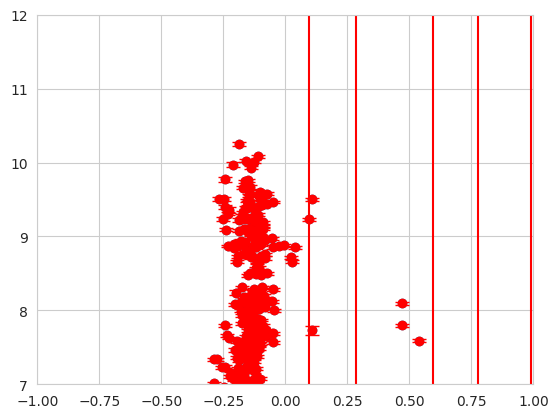

In [56]:
import seaborn as sns

#sns.kdeplot(replace_nans(weak_carbon_catalog['W1mag'].tolist()), color='blue', fill=True, linewidth=2,)
x = np.array(replace_nans(weak_carbon_catalog['W1mag'].tolist())) - np.array(replace_nans(weak_carbon_catalog['W2mag'].tolist()))
y = np.array(replace_nans(weak_carbon_catalog['W1mag'].tolist()))
yerr = np.abs(replace_nans(weak_carbon_catalog['e_W2mag'].tolist()))
plt.scatter(
    np.array(replace_nans(weak_carbon_catalog['W1mag'].tolist())) - np.array(replace_nans(weak_carbon_catalog['W2mag'].tolist())),
    np.array(replace_nans(weak_carbon_catalog['W1mag'].tolist())),
)
plt.errorbar(x, y, yerr=yerr, fmt='o', capsize=5, color='red')
plt.xlim(-1, 1)
plt.ylim(7, 12)
plt.show()


In [49]:
yerr

array([ 3.000e-02,  3.070e-01,  2.020e-01,  2.800e-02,  2.400e-02,
        2.300e-02,  2.200e-02,  1.400e-01,  2.500e-02,  2.300e-02,
        2.200e-02,  2.300e-02,  2.200e-02,  3.370e-01,  2.400e-02,
        2.300e-02, -9.999e+03,  2.960e-01,  2.400e-02,  3.300e-02,
        2.200e-02,  3.500e-02,  2.450e-01,  2.400e-02,  2.810e-01,
        2.200e-02, -9.999e+03,  5.400e-02,  6.200e-02,  2.300e-02,
        2.300e-02,  8.600e-02,  1.500e-01,  2.700e-02,  2.100e-01,
        2.800e-02,  2.190e-01,  5.900e-02,  3.000e-02,  6.800e-02,
        1.380e-01,  2.300e-02, -9.999e+03,  1.610e-01,  2.600e-02,
        2.500e-02,  1.670e-01, -9.999e+03,  2.480e-01,  2.390e-01,
        2.100e-02,  1.430e-01,  2.300e-02,  3.000e-02,  1.300e-02,
        2.500e-02,  2.200e-02,  4.350e-01,  2.300e-02,  2.200e-02,
        2.200e-02,  2.200e-02,  3.600e-02,  1.940e-01, -9.999e+03,
        4.070e-01,  2.200e-02,  8.700e-02,  1.660e-01,  2.300e-02,
       -9.999e+03,  1.800e-02,  2.500e-02,  2.700e-02,  2.500e

In [14]:
replace_nans(weak_carbon_catalog['W1mag'].tolist())

[7.729,
 3.896,
 4.974,
 7.792,
 9.036,
 8.821,
 8.142,
 5.136,
 7.884,
 9.101,
 8.655,
 8.823,
 9.499,
 5.867,
 8.996,
 9.549,
 1.488,
 3.798,
 8.01,
 7.34,
 9.191,
 7.234,
 4.169,
 7.755,
 4.234,
 8.761,
 0.029,
 6.757,
 7.133,
 8.043,
 9.106,
 6.32,
 5.656,
 7.716,
 5.104,
 7.462,
 4.847,
 6.857,
 7.213,
 6.605,
 5.819,
 3.139,
 -0.778,
 5.25,
 7.431,
 7.628,
 5.227,
 -9999,
 4.324,
 4.769,
 8.886,
 5.486,
 8.475,
 6.485,
 8.875,
 7.827,
 9.58,
 3.505,
 9.136,
 9.048,
 8.976,
 8.955,
 7.214,
 4.826,
 -0.176,
 3.57,
 8.499,
 6.055,
 5.818,
 9.555,
 -9999,
 7.726,
 9.386,
 10.25,
 9.503,
 8.731,
 9.451,
 8.93,
 9.108,
 5.62,
 7.881,
 6.685,
 7.086,
 5.847,
 7.304,
 6.931,
 6.322,
 6.273,
 6.401,
 5.091,
 6.448,
 4.249,
 8.861,
 -9999,
 9.396,
 9.357,
 -9999,
 9.507,
 -9999,
 4.966,
 6.239,
 9.234,
 6.07,
 7.005,
 8.938,
 9.23,
 8.852,
 5.273,
 9.505,
 8.898,
 9.309,
 9.235,
 5.262,
 5.598,
 8.879,
 7.994,
 9.03,
 8.657,
 -9999,
 7.909,
 8.248,
 8.186,
 7.798,
 9.772,
 6.68,
 8.509,
 6